# EDA for Wildfire detection - Part 3 (Hypothesis Testing)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from IPython.display import display
from scipy.stats import ttest_ind, norm, f
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [2]:
from myLib import check_missing, check_column_sources, check_missing_row_overlap, check_missing_and_plot, plot_missing_spatial

## 1. Prepare fire event dataframe (Cleaned)

Read the following csv files:
- Read Parsed_Table_3 into 'df_table3'
- Read Firegrowth_pts_v1_1_2023 into 'df_cfsds_pts_2023'
- Read modis_2023_Canada into 'df_modis_2023'
- Read viirs-snpp_2023_Canada into 'df_virrs_2023'
(Parsed_Table_3 is the csv version of Table 3 mentioned in "The Canadian Fire Spread Dataset.pdf")

In [2]:
path = "../output/fire_events_df_2023.csv"
fire_events_df_2023 = pd.read_csv(path)
print(f"Load dataframe from {path}, \nShape: {fire_events_df_2023.shape}")
display(fire_events_df_2023.head())

Load dataframe from ../output/fire_events_df_2023.csv, 
Shape: (408, 58)


,ID,year,fire_number,ignition_date,lon,lat,modis_acq_date,detection_delay_days,DOB,fireday,...,nonfuel5k,nonfuel10k,dem,slope,twi,aspect,cumuarea,pctgrowth,prevgrow,sprdistm
0,2023_1,2023,1,2023-07-13,-120.132411,65.169616,2023-07-14,1,194,1,...,0.388660,0.434968,160.333328,2.923349,8.141331,0.184916,55.89,0.0,0.0,843.571918
1,2023_2,2023,2,2023-07-21,-115.510326,66.083561,2023-07-22,1,202,1,...,0.422344,0.414876,423.444458,7.380778,4.917335,67.092438,75.33,0.0,0.0,979.352515
2,2023_3,2023,3,2023-07-25,-116.750961,65.775854,2023-07-26,1,206,1,...,0.315463,0.292883,386.222229,15.139147,5.079659,180.293304,34.02,0.0,0.0,658.145951
3,2023_10,2023,10,2023-07-01,-131.612507,65.975299,2023-07-03,2,182,1,...,0.317330,0.253425,234.000000,0.979205,5.813332,161.413071,2.43,0.0,0.0,175.896904
4,2023_11,2023,11,2023-07-29,-127.447260,67.987183,2023-08-02,4,210,1,...,0.013489,0.086612,209.888885,2.824383,6.089895,29.511507,5.67,0.0,0.0,268.686959


## 2. Remoteness-Related Variables (with Definitions)
Features related to remoteness are listed and shown bellow:
| **Variable**     | **Description** |
|------------------|-----------------|
| `roaddist`       | Distance to the nearest major road or railway (in meters). Higher values indicate lower accessibility. |
| `roaddens2k`     | Road density within 2 km radius (km/km²). Lower values suggest more remote areas. |
| `roaddens5k`     | Road density within 5 km radius. A proxy for local infrastructure presence. |
| `roaddens10k`    | Road density within 10 km radius. Captures mid-range access to road networks. |
| `roaddens25k`    | Road density within 25 km radius. Represents regional road connectivity. |
| `hydrodens2k`    | Proportion of surface water within 2 km. Very low values may suggest remote, arid, or undeveloped land. |
| `hydrodens5k`    | Proportion of surface water within 5 km. |
| `hydrodens10k`   | Proportion of surface water within 10 km. |
| `hydrodens25k`   | Proportion of surface water within 25 km. |
| `nonfuel1k`      | Proportion of land considered non-burnable within 1 km (e.g., rock, wetland, tundra). |
| `nonfuel2k`      | Same as above but within 2 km radius. |
| `nonfuel5k`      | Same as above but within 5 km radius. |
| `nonfuel10k`     | Same as above but within 10 km radius. High values may reflect remote landscapes. |
| `ecozone`        | Ecozone classification (e.g., Boreal Shield, Taiga). Some zones are naturally less populated and less accessible. |
| `dem`            | Elevation above sea level (meters). High altitudes may reduce accessibility. |
| `slope`          | Degree of slope. Steep terrain is harder to access and often remote. |
| `twi`            | Topographic Wetness Index. High values suggest wetter areas, which may hinder accessibility. |


## 3. Check the correlations between these variables and detection_delay_days

In [3]:
# Drop rows with missing target values
df_clean = fire_events_df_2023.dropna(subset=["detection_delay_days"])

# Define remoteness-related variables
remoteness_cols = [
    "roaddist",
    "roaddens2k", "roaddens5k", "roaddens10k", "roaddens25k",
    "hydrodens2k", "hydrodens5k", "hydrodens10k", "hydrodens25k",
    "nonfuel1k", "nonfuel2k", "nonfuel5k", "nonfuel10k",
    "dem", "slope", "twi"
    # 'ecozone' is excluded since it's categorical
]

# Filter out the columns that exist and are numeric
valid_cols = [col for col in remoteness_cols if col in df_clean.columns and pd.api.types.is_numeric_dtype(df_clean[col])]

# Compute correlation with detection_delay_days
correlations = df_clean[valid_cols + ["detection_delay_days"]].corr()
correlation_with_delay = correlations["detection_delay_days"].drop("detection_delay_days").sort_values(ascending=False)

# Print results
print(correlation_with_delay)


dem             0.106461
slope           0.085281
roaddens10k     0.025578
nonfuel10k      0.019157
roaddens5k      0.016394
roaddens25k     0.011648
nonfuel1k       0.000292
nonfuel5k      -0.012147
nonfuel2k      -0.015954
roaddens2k     -0.028004
roaddist       -0.039454
hydrodens2k    -0.047265
twi            -0.048398
hydrodens10k   -0.050503
hydrodens25k   -0.058162
hydrodens5k    -0.066508
Name: detection_delay_days, dtype: float64


We examined the correlation between remoteness-related variables and wildfire detection delay (in days). After dropping rows with missing target values, we selected numeric features related to terrain, road and hydro density, and fuel type. Among all variables, elevation (dem) and slope showed the highest correlation with detection delay, at 0.106461 and 0.085281 respectively. All other features had weak correlations (below 0.03), suggesting that detection delay is only weakly related to geographic remoteness or terrain characteristics.

## 4. MLR

In [11]:
valid_cols = [col for col in remoteness_cols if col in df_clean.columns and pd.api.types.is_numeric_dtype(df_clean[col])]
X = df_clean[valid_cols].dropna()
y = df_clean.loc[X.index, "detection_delay_days"]

# MLR
X_const = sm.add_constant(X)
mlr_model = sm.OLS(y, X_const).fit()
print(mlr_model.summary())

                             OLS Regression Results                             
Dep. Variable:     detection_delay_days   R-squared:                       0.026
Model:                              OLS   Adj. R-squared:                 -0.014
Method:                   Least Squares   F-statistic:                    0.6429
Date:                  Sat, 05 Jul 2025   Prob (F-statistic):              0.849
Time:                          23:26:55   Log-Likelihood:                -1930.1
No. Observations:                   408   AIC:                             3894.
Df Residuals:                       391   BIC:                             3962.
Df Model:                            16                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.0956     

We conducted a multiple linear regression (MLR) analysis using remoteness-related features to predict wildfire detection delay (detection_delay_days). The regression model yields a very low R-squared value of 0.026, indicating that the selected features explain only 2.6% of the variation in detection delay. The adjusted R-squared is even lower (-0.014), suggesting poor model fit.

Most of the coefficients are not statistically significant (p-values > 0.05), except for a few variables like:

roaddens5k (p = 0.020)

nonfuel2k (p = 0.036)

This indicates that, overall, remoteness-related variables (such as road/hydro/fuel density or elevation) do not strongly influence detection delay. These findings align with previous correlation analysis, reinforcing the idea that detection delays may depend on other unobserved factors beyond geographical remoteness.

## 5. T-Test: Compare Remote vs Accessible

### Hypotheses:
- H₀: Mean detection delay (Remote) = Mean detection delay (Accessible)
- H₁: Mean detection delay (Remote) ≠ Mean detection delay (Accessible)



In [5]:
# Define Remote vs Accessible（roaddist > 10,000）
df_clean["region_type"] = df_clean["roaddist"].apply(lambda x: "Remote" if x > 10000 else "Accessible")
remote = df_clean[df_clean["region_type"] == "Remote"]["detection_delay_days"]
accessible = df_clean[df_clean["region_type"] == "Accessible"]["detection_delay_days"]
t_stat, p_val = ttest_ind(remote.dropna(), accessible.dropna(), equal_var=False)
print(f"\nT-Test:\nt = {t_stat:.3f}, p = {p_val:.3f}")

alpha = 0.05
if p_val < alpha:
    print("\nConclusion: Reject H₀. There is a statistically significant difference in detection delay.")
else:
    print("\nConclusion: Fail to reject H₀. No statistically significant difference found.")


T-Test:
t = -1.491, p = 0.138

Conclusion: Fail to reject H₀. No statistically significant difference found.


### Result:
  t = -1.491, p = 0.138

Conclusion: Fail to reject H₀. No statistically significant difference found.

We performed independent two-sample t-tests to compare wildfire detection delays between remote and accessible regions. In the first test, regions were categorized based on roaddist > 10,000, and the result showed no statistically significant difference between the two groups (t = -1.491, p = 0.138).

- Do T-test for all remoteness features.

In [19]:
import pandas as pd
from scipy.stats import ttest_ind

def test_remoteness_significance(df, delay_column="detection_delay_days"):
    # Define remoteness-related variables
    remoteness_cols = [
        "roaddist",
        "roaddens2k", "roaddens5k", "roaddens10k", "roaddens25k",
        "hydrodens2k", "hydrodens5k", "hydrodens10k", "hydrodens25k",
        "nonfuel1k", "nonfuel2k", "nonfuel5k", "nonfuel10k",
        "dem", "slope", "twi"
    ]

    # Store results
    ttest_results = []

    for col in remoteness_cols:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            threshold = df[col].median()
            df["region_type_tmp"] = df[col].apply(lambda x: "Remote" if x > threshold else "Accessible")

            remote = df[df["region_type_tmp"] == "Remote"][delay_column]
            accessible = df[df["region_type_tmp"] == "Accessible"][delay_column]

            t_stat, p_val = ttest_ind(remote.dropna(), accessible.dropna(), equal_var=False)

            ttest_results.append({
                "remoteness_variable": col,
                "threshold": round(threshold, 4),
                "t_stat": round(t_stat, 4),
                "p_value": round(p_val, 4),
                "significant": "Yes" if p_val < 0.05 else "No"
            })

    # Convert to DataFrame
    result_df = pd.DataFrame(ttest_results).sort_values(by="p_value")

    # Filter significant ones
    significant_vars = result_df[result_df["significant"] == "Yes"]

    if significant_vars.empty:
        print("All features have no statistically significant difference.")
    else:
        return significant_vars[["remoteness_variable", "p_value", "t_stat"]]


In [20]:
test_remoteness_significance(df_clean)

All features have no statistically significant difference.


We then extended the analysis to all remoteness-related variables (e.g., road density, hydro density, fuel coverage, elevation, slope). Each variable was split into "Remote" and "Accessible" using its median as a threshold, and t-tests were conducted individually. None of the variables showed statistically significant differences (p > 0.05) in detection delay.

These findings suggest that geographic remoteness does not have a significant impact on wildfire detection delay in the analyzed dataset.

## 6. Decision Tree Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

We trained a Decision Tree Regressor to predict wildfire detection delay using remoteness-related features. The tree was limited to a maximum depth of 4 for interpretability.

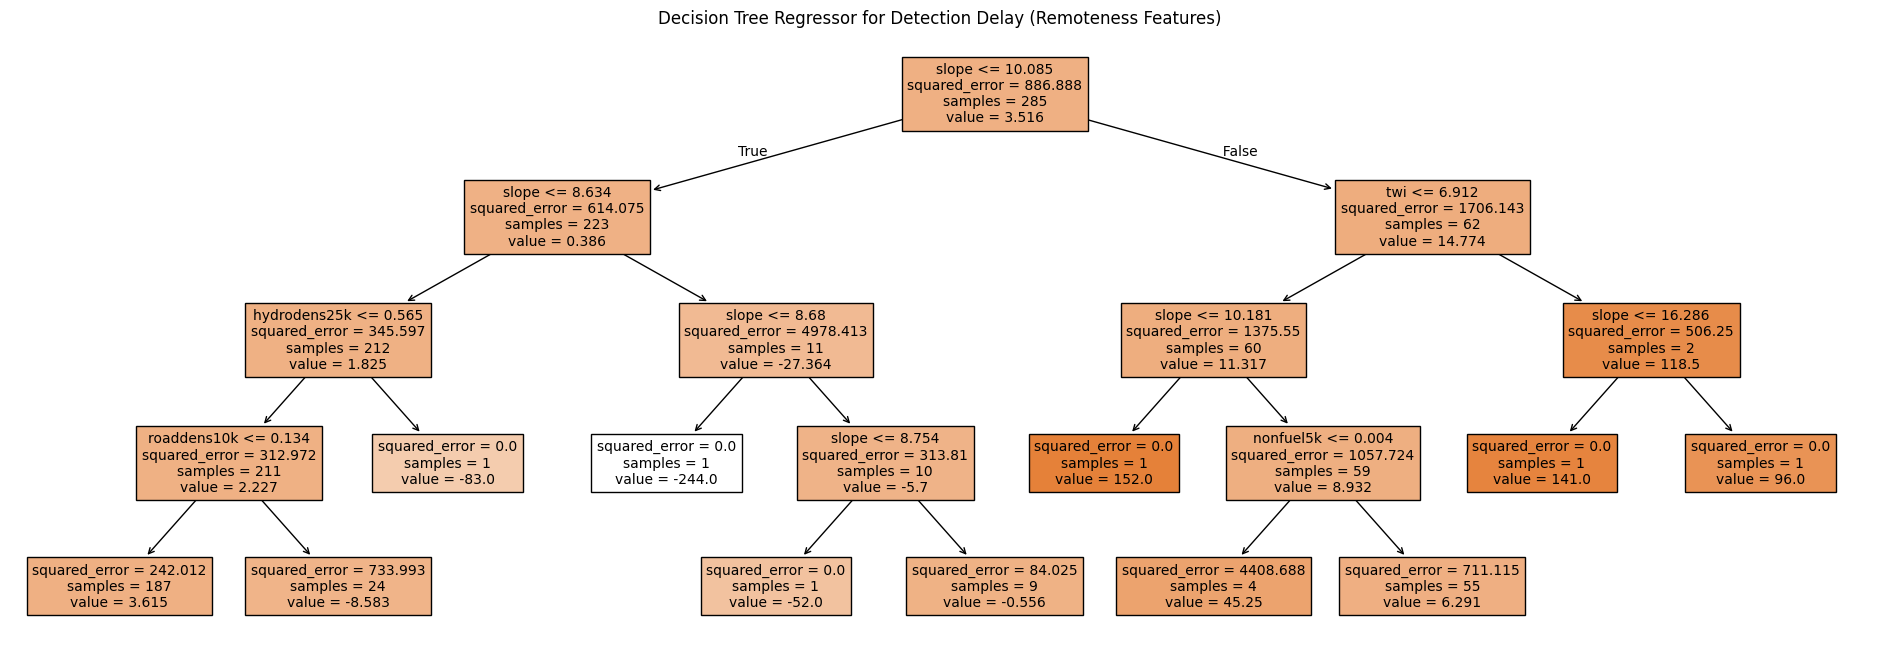

In [17]:
plt.figure(figsize=(24, 8))
plot_tree(tree, feature_names=X.columns, filled=True, fontsize=10)
plt.title("Decision Tree Regressor for Detection Delay (Remoteness Features)")
plt.show()

In [16]:
importances = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances (Decision Tree):")
print(importances)


Feature Importances (Decision Tree):
slope           0.710780
twi             0.167955
hydrodens25k    0.054608
nonfuel5k       0.042750
roaddens10k     0.023907
roaddist        0.000000
roaddens2k      0.000000
roaddens5k      0.000000
roaddens25k     0.000000
hydrodens2k     0.000000
hydrodens5k     0.000000
hydrodens10k    0.000000
nonfuel1k       0.000000
nonfuel2k       0.000000
nonfuel10k      0.000000
dem             0.000000
dtype: float64


The most important predictor was slope, with a feature importance of 0.71, followed by twi (Topographic Wetness Index, 0.17) and hydrodens25k (0.06). Other features, such as road and fuel density variables, had minimal or zero contribution.

The decision tree revealed that certain thresholds of slope and wetness index were most influential in splitting the data, but overall model complexity remained low. This result suggests that terrain characteristics (especially slope) may play a more relevant role than access-based remoteness (e.g., road or hydro density) in affecting wildfire detection delay.

## Summary
Based on our regression, hypothesis testing, and tree-based analyses, we found that traditional remoteness indicators (e.g., distance to roads, road density) had no significant impact on wildfire detection delay in the CFSDS dataset.

This is consistent with the nature of the CFSDS detection method, which relies primarily on satellite-based MODIS/VIIRS active fire detections. Unlike ground-based patrol or citizen reports, satellite observations are globally consistent and not directly limited by human access or infrastructure presence.

Therefore, it is reasonable to conclude that in the context of CFSDS, remoteness—defined in terms of road access or ecozones—does not play a major role in determining detection delay. However, other geographic and environmental factors (e.g., slope and surface wetness) may still affect satellite detection efficiency.